evt ICA op de features?

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt


import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import groups_of_features
from groups_of_features import _frontal, _central, _parietal, _alpha, _theta, _beta, _low_gamma, _high_gamma

plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 18,
    'axes.xmargin': 0,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
})

c:\Users\scbui\OneDrive\Documents\Master_BMS_PSN\Research_project_2_Unravel\Python\important_features\groups_of_features.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("../features_tweaked.csv")


In [2]:
features = pd.read_csv("../features_tweaked.csv")

C:\Users\scbui\AppData\Local\Temp\ipykernel_15132\1846429560.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("../features_tweaked.csv")


In [3]:
metadata_columns = ['Respondent', 'Participant_ID', 'mean_rating', 'Participant_ID_short',
       'image_number', 'individual_ratings', 'ID', 'Type', "class", "Missing"]

dropping_columns = metadata_columns +  _theta + _beta + _low_gamma + _high_gamma + _alpha
X1 = features.drop(dropping_columns, axis = 1)

all_columns = set(X1.columns)
columns_to_drop = set(_frontal + _central)
columns_to_drop2 = columns_to_drop.intersection(all_columns)

X = X1.drop(columns_to_drop2, axis = 1)
y = features["individual_ratings"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_model(_X, _y):

    n = _X.shape[1]

    model = keras.models.Sequential()
    model.add(Dense(n, input_shape = _X.shape[1:], activation="relu"))
    model.add(Dense(300, activation="relu"))
    model.add(Dense(200, activation="relu")) # less layers seem to work a bit better...
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1)) #Only one output node because its a regression model

    opt = Adam(learning_rate = 1e-4) # 1e-4 works for adam, Adam allows you to adjust the learning rate
    model.compile(loss="mean_squared_error", optimizer=opt) #This is a commen loss function

    history = model.fit(_X, _y, epochs = 10, validation_split = 0.1, verbose = 0)

    return model, history

### Train $N_{models}$ models

In [4]:
RMSEs = []
stds = []
HIS = []
temp_RMSEs = []
for i in range(10): #Each model is trained x times

    _m, history = train_model(X_train_scaled, y_train)

    performance = np.sqrt(np.mean((_m.predict(X_test_scaled[0:]).flatten() - np.array(y_test))**2))
    HIS.append(history.history)
    temp_RMSEs.append(performance)
print(f"Temp_RMSE = {temp_RMSEs}")

RMSEs.append(np.mean(temp_RMSEs))
stds.append(np.std(temp_RMSEs))

print(f"Model total performance: {RMSEs} +- {stds}")



10/10 [==============================] - 0s 2ms/step
Temp_RMSE = [1.9534429372755455, 1.9632042615337715, 1.9787184487856981, 1.9601952994097813, 1.9681557988892195, 1.984044078534594, 1.969478990131907, 1.964938055095338, 1.9692074760694616, 1.9608451836632317]
Model total performance: [1.9672230529388546] +- [0.008522430720840834]


In [22]:

np.save("keep_parietalalpha_all_RMSEs.npy", temp_RMSEs)


In [5]:
temp_RMSEs

[2.0495888521935663,
 2.084219827072967,
 2.0286717398771237,
 2.026959380385926,
 2.038023130870531,
 1.9929929991963697,
 1.9984322848744678,
 2.0263803455154488,
 2.03326541921743,
 2.034261099635827]

In [10]:
_m.predict(X_train_scaled[0:30])

1/1 [==============================] - 0s 52ms/step


array([[4.2310424],
       [4.932312 ],
       [2.9425714],
       [3.4746065],
       [3.6613116],
       [4.4505634],
       [3.9226425],
       [4.031563 ],
       [3.4492953],
       [3.8232539],
       [3.8897424],
       [3.63457  ],
       [3.786586 ],
       [3.491217 ],
       [3.7957077],
       [4.5657983],
       [3.8136163],
       [3.8918455],
       [4.228386 ],
       [3.6242838],
       [3.855716 ],
       [3.2598815],
       [3.8940775],
       [3.5334184],
       [3.8017006],
       [3.7533836],
       [3.8280315],
       [3.878041 ],
       [3.8010757],
       [2.9634368]], dtype=float32)

# Plot history: 95% CI

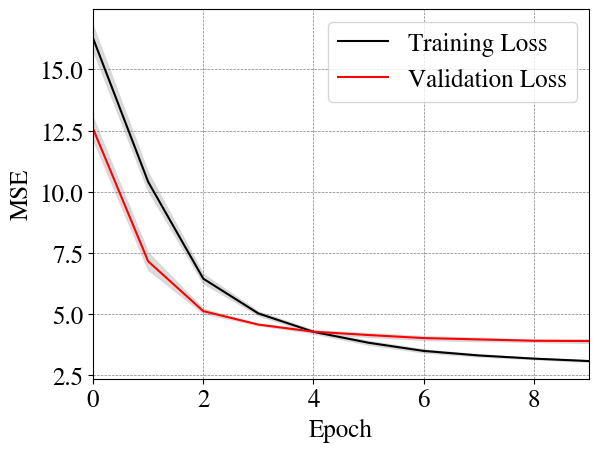

In [41]:
losses = [history["loss"] for history in HIS]
val_losses = [history["val_loss"] for history in HIS]

mean_loss = np.mean(losses, axis=0)
std_loss = np.std(losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

plt.figure()

# Plot mean lines
plt.plot(mean_loss, label='Training Loss', color='black')
plt.plot(mean_val_loss, label='Validation Loss', color='red')

# Plot 95% CI for training loss
plt.fill_between(range(len(mean_loss)),
                 mean_loss - 1.96 * std_loss / np.sqrt(len(losses)),
                 mean_loss + 1.96 * std_loss / np.sqrt(len(losses)),
                 color='lightgrey', alpha=0.8)

# Plot 95% CI for validation loss
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - 1.96 * std_val_loss / np.sqrt(len(losses)),
                 mean_val_loss + 1.96 * std_val_loss / np.sqrt(len(losses)),
                 color='lightgrey', alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xlim(0, 9)
plt.grid()
plt.legend()
plt.show()

# Plot history: loss lijn per model

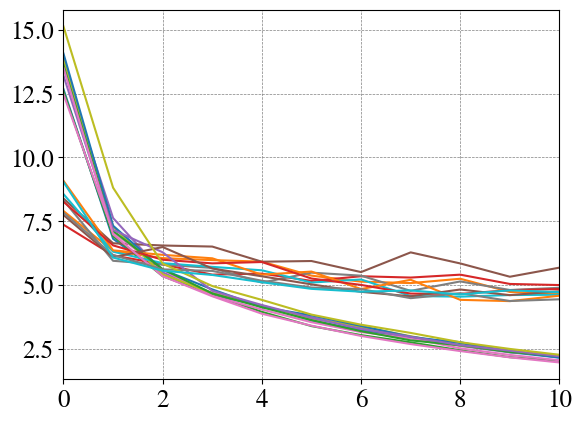

In [18]:
plt.figure()
for i, history in enumerate(HIS):
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
# plt.xlim(0,14)
plt.grid()
plt.show()

In [79]:
print(f"Model total performance: {np.mean(RMSEs):.3f} +- {np.std(RMSEs):.3f}")

Model total performance: 5.215 +- 0.271


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 341)               116622    
                                                                 
 dense_22 (Dense)            (None, 50)                17100     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 133773 (522.55 KB)
Trainable params: 133773 (522.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
76/76 [==============================] - 2s 9ms/step - loss: 14.7894 - val_loss: 11.8491
Epoch 2/50
76/76 [==============================] - 0s 6ms/step - loss: 10.3034 - val_loss: 10.7579
Epoch 3/50
76/76 [==============================] - 1s 7ms/step - loss: 8

<Figure size 640x480 with 0 Axes>

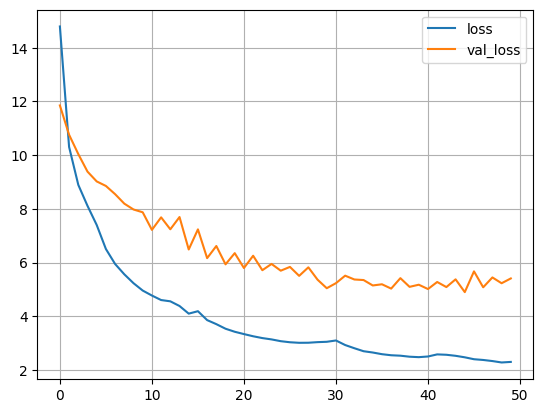

In [ ]:
# %%capture

n = X_train_scaled.shape[1]

model = keras.models.Sequential()
model.add(Dense(n, input_shape = X_train_scaled.shape[1:], activation="relu"))
# model.add(Dense(100, activation="relu")) # less layers seem to work a bit better...
model.add(Dense(50, activation="relu"))
model.add(Dense(1))

print(model.summary())

opt = Adam(learning_rate = 1e-4) # 1e-4 works for adam 
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(X_train_scaled, y_train, epochs = 50, validation_split = 0.1)

plt.figure()
pd.DataFrame(history.history).plot()
plt.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

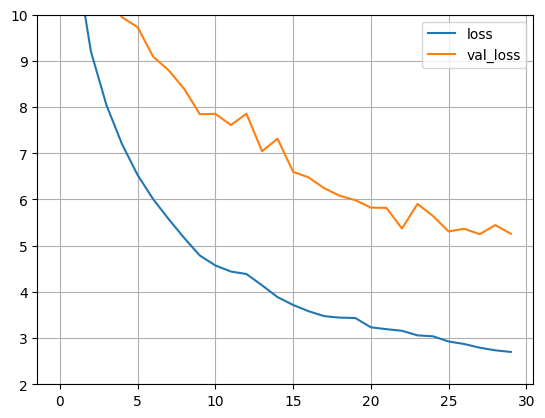

In [ ]:
plt.figure()
pd.DataFrame(history.history).plot()
plt.ylim(2, 10)
# plt.xlim(0, 10)

plt.grid()
plt.show()

In [ ]:
y_train

1151    6.0
73      5.0
1536    2.0
2709    7.0
621     2.0
       ... 
1638    3.0
1095    2.0
1130    7.0
1294    1.0
860     1.0
Name: individual_ratings, Length: 2700, dtype: float64

RMSE (Root Mean Squared Error): 

$\sqrt{\langle (y_{pred} - y_{true})^2 \rangle}$



In [ ]:
np.sqrt(np.mean((model.predict(X_test_scaled[0:]).flatten() - np.array(y_test))**2))

10/10 [==============================] - 0s 3ms/step


2.1392346654610703

# Random models

### How well does a random model perform? 

We simulate a randomly initialized model that can only output numbers from 1 - 7

Bij een (nog meer) random model is de RMSE rond de 4.2, bij het huidige model rond de 2.5, dus je wint wel bijna 2 punten

In [85]:
RMSEs = []
labels = []

for i in range(len(y_test)):
    labels.append(y_test.iloc[i])

for i in tqdm(range(10000)):
    y_random_predict = np.random.choice(labels)
    RMSEs.append(np.sqrt(np.mean((y_random_predict - np.array(y_test))**2)))

print(f"Random model performance: RMSE: {np.mean(RMSEs)} +- {np.std(RMSEs)}")

  9%|▊         | 860/10000 [00:00<00:01, 8549.40it/s]

100%|██████████| 10000/10000 [00:00<00:00, 10427.22it/s]

Random model performance: RMSE: 2.4975044649251257 +- 0.5753326518664182


In [86]:
_min = 1
_max = 7

RMSEs = []

for i in tqdm(range(10000)):
    y_random_predict = (np.random.rand(y_test.shape[0])) * 6 + 1
    RMSEs.append(np.sqrt(np.mean((y_random_predict - np.array(y_test))**2)))

print(f"Random model performance: RMSE: {np.mean(RMSEs)} +- {np.std(RMSEs)}")

100%|██████████| 10000/10000 [00:01<00:00, 7866.10it/s]

Random model performance: RMSE: 2.507370744521448 +- 0.07961011456105813
